# Oscar De la Cruz Echeveste
## Proyecto final
### 

In [2]:
#librerias a usar 
import matplotlib. pyplot as plt
import numpy as np
import random
import scipy
import scipy.special
import math
from scipy.optimize import minimize
import scipy.optimize as op
import scipy.stats as stats
from numpy.linalg import inv
%matplotlib inline

### IMPORTAMOS DATOS

In [3]:
#datos:
tb1 = np.loadtxt('jla_mub_covmatrix.dat')
tb2 = np.loadtxt('jla_mub.txt')
tb3 = np.loadtxt('jla_lcparams.txt', usecols=[1,2,4,6,8,10,12,13,14,15])

tb4 = np.loadtxt('jla_v0a_covmatrix.dat')
tb5 = np.loadtxt('jla_v0b_covmatrix.dat')
tb6 = np.loadtxt('jla_v0_covmatrix.dat')
tb7 = np.loadtxt('jla_vab_covmatrix.dat')
tb8 = np.loadtxt('jla_va_covmatrix.dat')
tb9 = np.loadtxt('jla_vb_covmatrix.dat')

# divido los datos de jla_mub.txt en dos arrelgos z y mu 
z=tb2[:,0]
mu=tb2[:,1]

z_cmb = tb3[:,0]
z_hel = tb3[:,1]
mb = tb3[:,2]
x1 = tb3[:,3]   #estiramiento de la curvatura de luz (stretching of the light-curve) 
color = tb3[:,4]   # color de supernova a brillo máximo (supernova color at maximum brightness)
rdvar_3 = tb3[:,5]
tmax = tb3[:,6]
cov_m_s = tb3[:,7]
cov_m_c = tb3[:,8]
cov_s_c = tb3[:,9]

In [4]:
def acomodo_de_matriz(tbn):
    covmat = []
    N = int(math.sqrt(len(tbn)))
    for i in range(N):
        row=[]
        for j in range(N):
            row.append(tbn[(N*i)+j])
        covmat.append(row)
    return covmat

In [5]:
#arreglo los datos de jla_mud_covmatrix.dat en una matriz de 31x31
covmatrix = np.array(acomodo_de_matriz(tb1))
covmatrix.shape

(31, 31)

In [6]:
#Pongo las varianzas de la matriz anterior (que se encuentran en la diagunal) en un arreglo.  
var=[]
for i in range(31):
    var.append(covmatrix[i][i])

In [7]:
#matrices de covarianza
mag_covmat_file = np.array(acomodo_de_matriz(tb6))
stretch_covmat_file = np.array(acomodo_de_matriz(tb8))
colour_covmat_file = np.array(acomodo_de_matriz(tb9))
mag_stretch_covmat_file = np.array(acomodo_de_matriz(tb4))
mag_colour_covmat_file = np.array(acomodo_de_matriz(tb5))
stretch_colour_covmat_file = np.array(acomodo_de_matriz(tb7))

### GRAFICAMOS

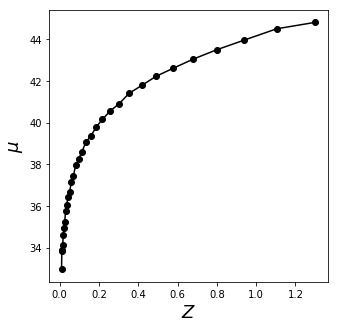

In [8]:
#Graficamos los datos de 'jla_mub.txt'
plt.figure(figsize = (5,5))
plt.plot(z, mu, 'ko-')
plt.xlabel('$Z$',fontsize = 18)
plt.ylabel('$\mu$',fontsize = 18)
plt.show()

Ahora, Definimos la $\mu_{\Lambda CDM}$ como ya se hizo en ejercicios anteriores:

In [9]:
def sss(omg):
    return ((1.0-omg)/omg)**(1.0/3)
def eta(a,omg):
    r = np.sqrt(np.power(sss(omg),3)+1)
    return 2*r*pow((1./a**4 - (0.1540*sss(omg)/(a**3))+(0.4304*pow(sss(omg),2)/(a**2))+(0.19097*pow(sss(omg),3)/(a**1))+(0.066941*pow(sss(omg),4))),-1.0/8)
def D_L(z,omg,H):
    return (299792.0/H)*(1.0+z)*(eta(1.0,omg)-eta((1.0/(1.0+z)),omg))
def mu_cdm(z,omg):
    return 25 + (5.0*np.log10(D_L(z,omg,70.0))) #Valor de H_0 = 70 km/s*Mpc

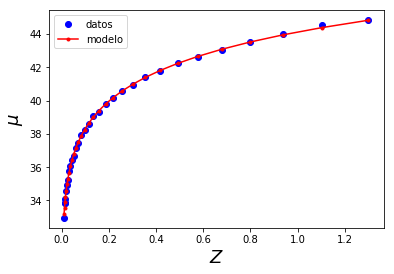

In [10]:
omg_true = 0.289
mu_true = mu_cdm(z, omg_true)

#graficamos mu_cdm con los datos de 'jla_mub.txt'
plt.xlabel('$Z$',fontsize = 18)
plt.ylabel('$\mu$',fontsize = 18)
plt.plot(z,mu,'bo',label = 'datos' )
plt.plot(z,mu_true,'r.-', label = 'modelo')
plt.legend()

La estimación de la distancia con SNe Ia se basa en la observación empírica de que estos eventos forman una clase homogénea cuya variabilidad restante está razonablemente bien captada por dos parámetros. Uno de ellos describe el tiempo de estiramiento de la curvatura de luz $X_1$ y el otro describe el color de supernova a brillo máximo $C$

Estimador de distancia:


\begin{equation}
\hat{\mu} = m_B^{\star} - (M_B - \alpha \times X_1 + \beta \times C)
\end{equation}


Donde $m_B^{\star}$ corresponde a la magnitud máxima observada en el marco de reposo B y $\alpha$, $\beta$ y $M_B$ son los nuisance parameters en el estimador de distancia.

In [11]:
# función para calcular mu gorrito
def mu_hat(theta,z,mb,x1,color): 
    Mb,delta_M,alf,bet,omg = theta
    mu = mb - (Mb + delta_M - alf*x1 + bet*color)
    return mu 

In [12]:
#Valores obtenidos en el artículo
alfa = 0.1147
beta = 0.0599
Mb = -19.04
delta_M = -0.0829
omg_m = 0.376

theta = Mb, delta_M, alfa, beta, omg_m

#Calculamos la mu gorrito y lcdm:
mu_h = mu_hat(theta,z_cmb,mb,x1,color)
mu_c = mu_cdm(np.sort(z_cmb),omg_m)

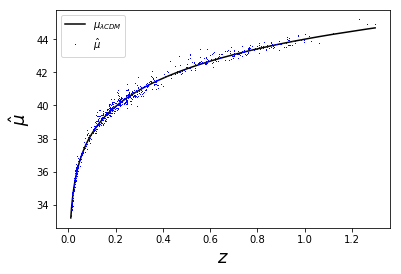

In [13]:
#Graficamos los datos: 
plt.plot(np.sort(z_cmb),mu_c,'k-',label = '$\mu_{\lambda CDM}$' )
plt.plot(z_cmb,mu_h,'b,',label = '$\hat{\mu}$' )
plt.xlabel('$z$',fontsize = 18)
plt.ylabel('$\hat{\mu}$',fontsize = 18)
plt.legend()

#### Minimización del Likelihood

Usando el estimador de distancia anterior, ajustamos una cosmología a las mediciones de supernovas minimizando la siguiente función:


\begin{equation}
\chi^2 = (\hat{\mu} - \mu_{\Lambda CDM}(z;\Omega_m))^{\dagger} C^{-1} (\hat{\mu} - \mu_{\Lambda CDM}(Z;\Omega))
\end{equation}


Donde $C$ es la matriz de covarianza de $\hat{\mu}$. Los parametros libres en el ajuste son $\Omega_m$ y los cuatro nuisance parameters $\alpha, \beta, M_B^{1}$ y $\Delta_M$

def lnlik (theta,z,mb,x1,color,C,var):
    #Parametrso iniciales
    Mb,delta_M,alf,bet,omg = theta
    C_1 = inv(C)
    V = mu_hat(theta,z,mb,x1,color)-mu_cdm(z,omg)
    chi_2 = np.inner(V.T,np.inner(C_1,V))
    return -0.5*np.sum(np.divide(chi_2,var))

In [14]:
def lnlik (theta,z,mb,x1,color,C,var):
    #Parametrso iniciales
    Mb,delta_M,alf,bet,omg = theta
    C_1 = inv(C)
    modelo = mu_hat(theta,z,mb,x1,color)
    y = mu_cdm(z,omg)
    #chi_2 = np.inner(V.T,np.inner(C_1,V))
    inv_sigma2 = np.divide(1.0,(var))
    return -0.5*(np.sum((y-modelo)**2*inv_sigma2 - np.log(inv_sigma2)))

Hacemos la matriz de covarianza sumando cada una de las anteriores:

In [15]:
#matriz de covarianza:
Cov = mag_covmat_file + stretch_covmat_file + colour_covmat_file + mag_stretch_covmat_file + mag_colour_covmat_file + stretch_colour_covmat_file
var = np.diag(Cov)

#### Primera estimación

In [16]:
Mb_ini, delta_M_ini, alf_ini, bet_ini, omg_ini = -19.0, -0.065, 0.125, 4.5, 0.289 
nll = lambda *args: -lnlik(*args)
bounds = ((-20.0,-18.0),(-0.05,-0.2),(0.1,0.2),(2.9,3.5),(0.05,0.4))
result = op.minimize(nll, [Mb_ini, delta_M_ini, alf_ini, bet_ini, omg_ini], args=(z_cmb,mb,x1,color,Cov,var), method='Nelder-Mead', tol=1e-6)
Mb_ml,delta_M_ml,alf_ml, bet_ml, omg_ml = result["x"]

Valores de la primera estimación $M_b$, $\Delta M_b$, $\alpha$,  $\beta$ y $\Omega_m$:

In [17]:
print(Mb_ml,delta_M_ml,alf_ml, bet_ml, omg_ml)

(-19.00478055815575, -0.10194478636155563, 0.11437996460844527, 2.0186564739188415, 0.3250476266621044)


Graficamos los datos segun el modelo $\hat{\mu}$ con los valores obtenidos arriba y comparamos con los valores reales y la $\mu_{\lambda CDM}$

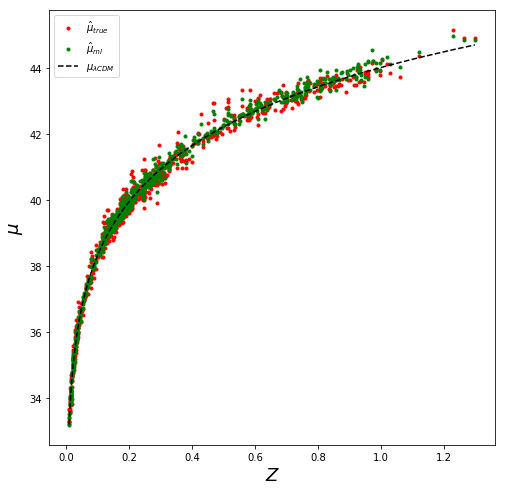

In [18]:
plt.figure(figsize=(8,8))
plt.xlabel('$Z$',fontsize=18)
plt.ylabel('$\mu$',fontsize=18)

theta_ml = Mb_ml,delta_M_ml,alf_ml, bet_ml, omg_ml

mu_true = mu_hat(theta,z,mb,x1,color)
mu_ml = mu_hat(theta_ml,z,mb,x1,color)

plt.plot(z_cmb,mu_true,'r.',label = '$\hat{\mu}_{true}$')
plt.plot(z_cmb,mu_ml,'g.',label = '$\hat{\mu}_{ml}$')
plt.plot(np.sort(z_cmb),mu_c,'k--',label = '$\mu_{\lambda CDM}$')
plt.legend()

#### Uso del EMCEE
Definimos el prior como una distribución uniforme:

In [19]:
def lnprior(theta):
    Mb, delta_M, alfa, beta, omg = theta
    if -0.4*10**15 < Mb < 0.4*10**15 and -0.4*10**15 < delta_M < 0.4*10**15 and 0.05 < alfa < 0.25 and -5.0 < beta < 5.0 and 0.1 < omg < 1.0:
        return 0.0
    return -np.inf

In [20]:
def lnprob(theta,z,mb,x1,color,C,var):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlik(theta,z,mb,x1,color,C,var)

In [23]:
n_dim, n_walker = 5, 100 #100 caminadores 
pos = [result["x"] + 1e-4*np.random.randn(n_dim) for i in range(n_walker)]

In [24]:
import emcee 
sampler = emcee.EnsembleSampler(n_walker, n_dim, lnprob , args=(z_cmb,mb,x1,color,Cov,var))
sampler.run_mcmc(pos,200)
print()

()


Graficamos los caminadores:

/home/echeveste/.local/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


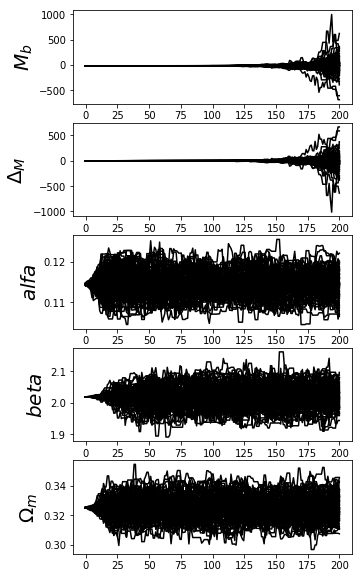

In [25]:
x_g = np.linspace(0.0, 200, 200)

plt.figure(figsize=(5,10))
for i in range(n_walker):
    plt.subplot(5, 1, 1)
    plt.plot(x_g, sampler.chain[i,:,0], 'k-')
    plt.ylabel('$M_{b}$',fontsize = 20)

    plt.subplot(5, 1, 2)
    plt.plot(x_g, sampler.chain[i,:,1], 'k-')
    plt.ylabel('$\Delta_{M}$',fontsize = 20)
    
    plt.subplot(5, 1, 3)
    plt.plot(x_g, sampler.chain[i,:,2], 'k-')
    plt.ylabel('$alfa$',fontsize = 20)
    
    plt.subplot(5, 1, 4)
    plt.plot(x_g, sampler.chain[i,:,3], 'k-')
    #plt.plot(x_g, beta_true*np.ones(500), '-')
    plt.ylabel('$beta$',fontsize = 20)
        
    plt.subplot(5, 1, 5)
    plt.plot(x_g, sampler.chain[i,:,4], 'k-')
    plt.ylabel('$\Omega_m$',fontsize = 20)
    
plt.show()

In [34]:
samples = sampler.chain[:, 160:, :].reshape((-1, n_dim))

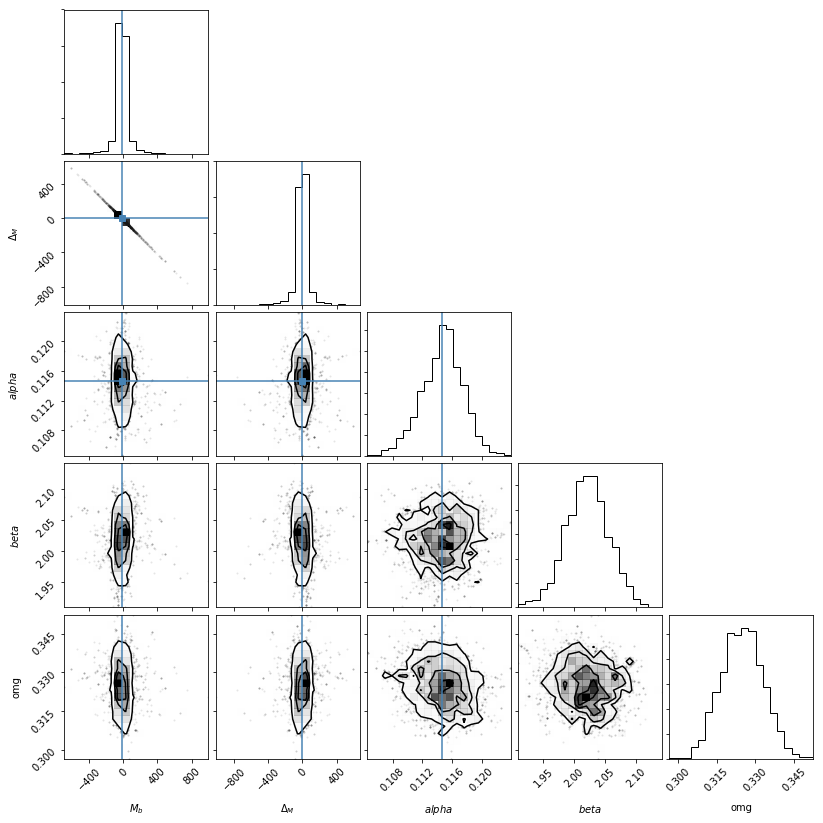

In [40]:
import corner
fig = corner.corner(samples, labels=["$M_{b}$", "$\Delta_{M}$", "$alpha$", "$beta$","omg"],
                      truths=[Mb, delta_M, alfa, beta, omg_m])
fig.savefig("triangle(2).png")